In [1]:
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline


### Derivative
In simple words the derivative means what happen if we dumped up or down one the values what kind of effect it will have on outcome of the equation. (the derivative shows the sensitivity of change of a function's output with respect to the input)

For instance:
  f(x) = (f(x + h) - f(x))/h

  where h is the amount of change.

  Slope = Change in Y Change in X = ΔyΔx. rise and run

In [2]:
class Value:

  def __init__(self, data, _childern=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_childern)
    self._op = _op
    self.label = label

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # This is based on the chain rule of differentiation, which says that the
      # gradient of the `output` with respect to `self` is equal to the gradient of
      # the `output` with respect to `out` times the gradient of `out` with respect to `self` 
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad
    out._backward = _backward
    return out
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f"**{other}")

    def _backward():
      self.grad += other * (self.data ** (other -1)) * out.grad
    
    out._backward = _backward

    return out

  def __truediv__(self, other):
    return self * (other**-1)

  def __repr__(self):
    return f"Value (data: {self.data})"

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out =  Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2)*out.grad 
    out._backward = _backward
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward(self):
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    # Algorithm: There are several algorithms for finding a topological ordering.
    # One of the most well-known algorithms is based on depth-first search (DFS). Here are the general steps:
    # Start at an arbitrary node.
    # Explore its neighbors and mark them as visited.
    # Recursively apply the same process to unvisited neighbors.
    # Add the current node to the beginning of the topological ordering when all its neighbors have been explored.

    topo = []
    visited = set()
    def build_typo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_typo(child)
        topo.append(v)
    build_typo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
  




In [3]:
a = Value(2.0, label='A')
b = Value(-3.0, label='B')
c = Value(10.0, label='C')
e = a*b; e.label='E'
d = e + c; d.label='D'
f = Value(-2.0, label='f')
L = f * d; L.label='L'
L

Value (data: -8.0)

In [4]:

def trace(root):

  # sets for all set and nods in graph.
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)

  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)

  for n in nodes:

    uid = str(id(n))
    # for any value on graph creating a rectangular node
    dot.node(name=uid, label="{ %s | data%.4f | grad%.4f } " % (n.label, n.data, n.grad), shape='record')

    if n._op:
      # if this value is result of some operation them create a node for it
      dot.node(name=uid + n._op, label=n._op)

      # connect this node to it
      dot.edge(uid+ n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

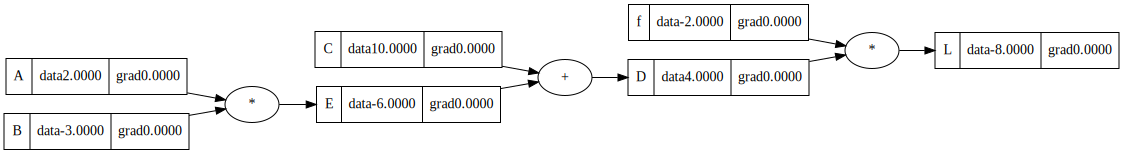

In [5]:
draw_dot(L)

In [6]:
# Finding the Gradient value for each of the node.
# we will use: rise over run
# this will give us the idea how much the slope change if we nudges the value by h.
# (f(x + h) - f(x)) / h

# the value of dL/dL  = ?
# L = f * d  as we know the L is
# ((L + h ) - L) / h
# L + h - L = h = 1
# therefore the value of L is 1.0
L.grad = 1.0

# dL/dD = ?
# L = f*d
# ((d + h) * f - d*f)/h
# df + hf - df / h = f
d.grad = f.data

# dL/dF = ?
# L = f*d
# ((f+h)*d - (fd))/h
# fd + hd - fd / h
# d
f.grad = d.data

# dL/dC = ?
# to find derivative of DL to DC we will use Chain Rule.
# dL/dC = (dL/dD) * (dD/dC)
# dD/dC = ?
# d = e + c
# ((e + c + h) - (e+c)/h)
# (e + c + h -e -c)/h = 1
# therefore: dL/dC = (dL/dD) * (dD/dC)
# dL/dC = f.data * 1
c.grad = f.data * 1

# dL/dE = ?
# dL/dC = (dL/dD) * (dD/dE)
# (dD/dE) = ?
# d = e + c
# ((e + h + c) - (e + c))/h = 1
# dL / dE = 1
e.grad = 1 * f.data

# dL/da = ?
# dL/da = (dl/dD) * (dD/dE) * (dE/dA)
# dE/dA = ?
# a * b = e
# ((a + h)*b - (a*b))/h
# (a*b + b*h - a*b ) / h
# b*h/h
# dE/dA = b
a.grad = f.data * 1 * b.data

# dL/db = ?
# dL/db = (dl/dD) * (dD/dE) * (dE/dB)
# dE/dA = ?
# a * b = e
# ((a * (b + h)) - (a*b))/h
# (a*b + a*h - a*b ) / h
# a*h/h
# dE/dB = a
b.grad = f.data * 1 * a.data

In [7]:
## You can check the value of above derivative from the following equation.

def derivative():

  h = 0.0001

  a = Value(2.0, label='A')
  b = Value(-3.0, label='B')
  c = Value(10.0, label='C')
  e = a*b; e.label='E'
  d = e + c; d.label='D'
  f = Value(-2.0, label='f')
  L = f * d; L.label='L'
  L1 = L.data

  a = Value(2.0, label='A')
  b = Value(-3.0, label='B')
  c = Value(10.0, label='C')
  e = a*b; e.label='E'
  d = e + c; d.label='D'
  f = Value(-2.0, label='f')
  L = f * d; L.label='L'
  L2 = L.data + h         # L.data + h for grad of L

  print((L2 - L1)/h)

derivative()

0.9999999999976694


In [8]:
#  Inputs x1, x2;
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# adding weight to input
w1x1 = x1*w1; w1x1.label= 'w1x1'
w2x2 = x2*w2; w2x2.label= 'w2x2'

# adding all the weights and inputs
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'

# model
n = w1x1w2x2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

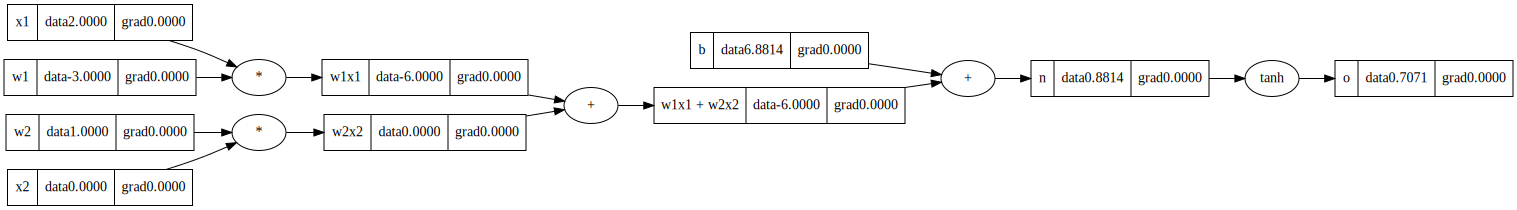

In [9]:
draw_dot(o)

In [10]:
o.grad = 1.0

In [11]:
o._backward()

In [12]:
n._backward()

In [13]:
w1x1w2x2._backward()

In [14]:
w2x2._backward()

In [15]:
w1x1._backward()

In [16]:
# Manually backpropogating through the network.
# Derivative of do/d0 = 1
o.grad = 1.0

# backpropogating through tanh.
# do/dn => 1 - tanh(n) ** 2
# as tanh(n) == o
# 1 - o ** 2
# 1 - (o.data) ** 2 == 0.4999999999999999
n.grad = 1 - (o.data) ** 2

# do/db = ?
# do/db = (dn/db) * (do/dn)
# dn/db = ?
# w1x1w2x2 + b = n
# ((w1x1w2x2 + b + h) - (w1x1w2x2 + b))/h
# w1x1w2x2 + b + h -w1x1w2x2 -b / h
# h/h = 1
b.grad = (1 - (o.data) ** 2 ) * 1

# do/dw1x1w2x2 = ?
# do/dw1x1w2x2 = do/dn * dn/dw1x1w2x2
# w1x1w2x2 + b = n
# ((w1x1w2x2 + h + b) - (w1x1w2x2 + b))/h
# w1x1w2x2 + h + b -w1x1w2x2 -b / h
# h/h = 1
w1x1w2x2.grad = (1 - (o.data) ** 2 ) * 1

# Note when there is a PLUS then the backpropogation will have exact same gradient as '+' work as distributor.
# do/dw2x2 = (dw1x1w2x2/ddw2x2) * (dn/dw1x1w2x2) * (do/dn)
# do/dw1x1 = (dw1x1w2x2/ddw1x1) * (dn/dw1x1w2x2) * (do/dn)
w2x2.grad = 1 * 1 * (1 - (o.data) ** 2 )
w1x1.grad = 1 * 1 * (1 - (o.data) ** 2 )

# do/dx1 => ?
# do/dx1 = (dw1x1/dx1) * (dw1x1w2x2/ddw1x1) * (dn/dw1x1w2x2) * (do/dn)
# dw1x1/dx1 = ?
# x1 * w1 = x1w1
# ((x1 + h)*w1 - (x1*w1))/h
# x1w1 + w1h - x1w1/h
# w1h/h
# w1
# dw1x1/dx1 = w1
x1.grad = w1.data * 1 * 1 * (1 - (o.data) ** 2 )


# do/dw1 => ?
# do/dw1 = (dw1x1/dw1) * (dw1x1w2x2/ddw1x1) * (dn/dw1x1w2x2) * (do/dn)
# dw1x1/dw1 = ?
# x1 * w1 = x1w1
# ((w1 + h)*x1 - (x1*w1))/h
# x1w1 + x1h - x1w1/h
# x1h/h
# x1
# dw1x1/dx1 = x1
w1.grad = x1.data * 1 * 1 * (1 - (o.data) ** 2 )


# do/dx2 => ?
# do/dx2 = (dw2x2/dx2) * (dw1x1w2x2/ddw2x2) * (dn/dw1x1w2x2) * (do/dn)
# dw2x2/dx2 = ?
# x2 * w2 = x2w2
# ((x2 + h)*w2 - (x2*w2))/h
# x2w2 + w2h - x2w2/h
# w2h/h
# w2
# dw1x1/dx1 = w1
x2.grad = w2.data * 1 * 1 * (1 - (o.data) ** 2 )
w2.grad = x2.data * 1 * 1 * (1 - (o.data) ** 2 )# similarly

In [17]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # parms = []
    # for neuron in self.neurons:
    #   parm = neuron.parameters()
    #   parms.extends(parm)
    # return parms


class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [parm for layer in self.layers for parm in layer.parameters()]



In [18]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value (data: -0.9140940280647334)

In [19]:
xs = [[2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]

In [20]:
# Lets apply mean square error to find the loss.
for epoch in range(10):

  # Foward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backfore backward pass make sure all the grad are reset to 0
  for p in n.parameters():
    p.grad = 0.0

  # backward pass
  loss.backward()

  # updating the parameters
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(f'epoch: {epoch}', f"loss, {loss.data}")

TypeError: unsupported operand type(s) for +: 'int' and 'Value'